Hough Transform for Circle Detection

In [ ]:
# Importing Libraries

import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import stats

**Edge Detection:**
__________________________________
1. **Convert the image to grayscale**:

   We first simplify the image by converting it to grayscale. This removes color information and keeps only brightness (intensity), which is what's needed for detecting edges. Working with a single channel also makes the processing much faster and easier.


2. **Define Sobel kernels for detecting gradients**:

   Sobel filters help us detect edges by highlighting areas where intensity changes quickly.

   * The `sobel_x` kernel is designed to detect vertical edges by measuring horizontal intensity changes. It places higher weight (`-2` and `2`) on the middle row to focus more on immediate neighbors and capture strong vertical features.

   * Similarly, the `sobel_y` kernel detects horizontal edges by capturing vertical intensity changes. It emphasizes the top and bottom rows for the same reason.


3. **Pad the image borders**:

   When we apply a 3×3 kernel near the edges of the image, it might try to access pixels outside the image. To avoid that, we pad the image with a border of zeros. This padding allows the Sobel filter to slide over every pixel in the original image safely.


4. **Apply Sobel filters to compute gradients**:

   We slide each Sobel kernel over the image and, at each location, compute how much the brightness changes in the x and y directions. This gives us two outputs: horizontal (`grad_x`) and vertical (`grad_y`) gradients for every pixel.


5. **Calculate the gradient magnitude**:

   The x and y gradients are combined to get the overall strength of the edge at each point. This tells us how strong the edge is, regardless of direction.
   

6. **Threshold the gradient**:

   If the edge strength at a pixel is greater than a pre-decided threshold, we consider it as an edge pixel. This helps eliminate weak edges that may arise due to noise in the input image.


7. **Return the edge map**:

   We return a binary image where edge points are marked as 1 (or 255), and everything else is 0. This output highlights only the strong edges in the image.



In [ ]:
# Edge Detection

def detect_edges(image, sobel_threshold=100):

    """Compute binary edge map of `image` using Sobel filter and magnitude threshold."""
    
    # Grayscaling the image
    gray = image.astype(float)
    if image.ndim == 3:
        # RGB to grayscale by luminosity method
        gray = 0.2989*image[:,:,0] + 0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    H, W = gray.shape
    
    # Sobel kernels for gradients
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=float)
    sobel_y = np.array([[ 1,  2,  1],
                        [ 0,  0,  0],
                        [-1, -2, -1]], dtype=float)
    
    # Pad image borders to handle edges
    pad_img = np.pad(gray, pad_width=1, mode='constant', constant_values=0)
    
    # Convolve Sobel kernels over the image
    grad_x = np.zeros_like(gray)
    grad_y = np.zeros_like(gray)
    for i in range(H):
        for j in range(W):
            # 3x3 region around pixel (i, j)
            region = pad_img[i:i+3, j:j+3]
            grad_x[i, j] = np.sum(region * sobel_x)
            grad_y[i, j] = np.sum(region * sobel_y)

    # Gradient magnitude
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)

    # Threshold to get binary edges
    edges = (grad_mag >= sobel_threshold)
    
    return edges.astype(np.uint8)  # edges as 0/1 (or 0/255) image

**Hough Circles: Summary**
____________________________________
* Hough Circle is used to detect circles in an image by using the votes of edge pixels. 
* Each edge point “guesses” where the center of a circle could be, based on its position and a set of possible radii. These guesses are stored as votes in an accumulator. 
* The spots in the accumulator with the highest number of votes represent the most likely centers of actual circles. 
* Optionally, we can clean up the results by merging overlapping circles.


**Hough Circles: Detailed Explanation (Step-by-step)**

_________________________________________________


1. **Radius range and creating accumulator array**

  * If no radius range is given, we use a default: 5 to half the image size.
  * We create a 3D _accumulator array_: one 2D layer per radius. Each cell holds the number of votes for a potential circle center at that radius.


2. **Precompute circle perimeter offsets**

  * For each radius `r`, we calculate integer `(dy, dx)` offsets for a circle using the formulas:

    ```
    dx = r * cos(theta)
    dy = r * sin(theta)
    ```
  * These (dx, dy) offsets tell us how far the point is from the center of the circle, in pixels. In other words, these offsets represent where an edge pixel could be on a circle with radius `r`. 
  * But instead of repeating this math every time, we precompute these offsets for each radius — once — and reuse them. This makes the process much faster.
  * We do this for 360 angles (0° to 359°) and round the values since pixel positions are integers.


3. **Voting: loop through edge pixels**

  * Now, we loop through each edge pixel (ey, ex) in the image. We treat that pixel as a possible point on the edge of some circle.
  * Using the precomputed (dy, dx) offsets for each radius, we guess where the center of that circle could be:

  * If (ey, ex) lies on the edge of a circle, then the center must be:
      ```
      center_y = ey - dy
      center_x = ex - dx
      ```
  * So for every edge pixel, and every possible radius, we calculate the possible center (center_x, center_y) — and we vote for it in our accumulator array.
  * More edge pixels that suggest the same center and radius = more votes (higher confidence).


4. **Find circle candidates via thresholding**

  * After voting, we scan the accumulator.
  * Any cell with votes ≥ `votes_threshold` is a potential circle.
  * We apply _non-maximum suppression_: in a local 3D neighborhood (defined by `region`), we only keep the strongest vote to avoid duplicates.


5. **(Optional) Post-processing: merging similar circles**

  * Circles close together (within `size` pixels) are grouped.
  * For each group, we compute the average (or min/max/median/mode) of their `(x, y, r)` values, depending on the `avg` argument.
  * This helps reduce noise and merge multiple detections of the same circle into one clean output.


6. **Return results**

  * If post-processing is used: return the merged circle list.
  * Otherwise: return the sorted list of circles (by vote strength).




In [ ]:
def hough_circles(edge_image, radius_range=None, votes_threshold=20, region=8, post_process=False, size=None, avg='mean'):
    
    """
    Perform Hough Circle Transform on a binary edge image.
    
    radius_range: (R_min, R_max) for circle search
    votes_threshold: minimum number of votes to accept circle
    region: suppression region size for non-maximum suppression
    post_process: whether to merge nearby circles
    size: neighborhood size for merging
    avg: how to compute average - 'mean', 'min', 'max', 'median', or 'mode'
    
    Returns list of detected circles as (x, y, r)
    """
    
    H, W = edge_image.shape
    if radius_range is None:
        R_min, R_max = 5, min(H, W) // 2
    else:
        R_min, R_max = radius_range
    if R_min < 1: R_min = 1

    acc = np.zeros((R_max+1, H + 2*R_max, W + 2*R_max), dtype=np.int32)

    theta = np.arange(0, 360) * np.pi / 180
    cos_vals = np.cos(theta)
    sin_vals = np.sin(theta)

    circle_offsets = {r: None for r in range(R_min, R_max+1)}
    for r in range(R_min, R_max+1):
        offset_set = set()
        for ang in range(360):
            dy = int(round(r * sin_vals[ang]))
            dx = int(round(r * cos_vals[ang]))
            offset_set.add((dy, dx))
        if offset_set:
            offset_list = np.array(list(offset_set))
            circle_offsets[r] = (offset_list[:, 0], offset_list[:, 1])

    edge_points = np.argwhere(edge_image > 0)
    for (ey, ex) in edge_points:
        for r in range(R_min, R_max+1):
            if circle_offsets[r] is None:
                continue
            dy_list, dx_list = circle_offsets[r]
            a_list = ey - dy_list
            b_list = ex - dx_list
            a_idx = a_list + R_max
            b_idx = b_list + R_max
            valid = (a_idx >= 0) & (a_idx < acc.shape[1]) & (b_idx >= 0) & (b_idx < acc.shape[2])
            acc[r, a_idx[valid], b_idx[valid]] += 1

    circles = []
    used = np.zeros_like(acc, dtype=bool)
    for r in range(R_min, R_max+1):
        candidates = np.argwhere(acc[r] >= votes_threshold)
        for (a_idx, b_idx) in candidates:
            if used[r, a_idx, b_idx]:
                continue
            votes = acc[r, a_idx, b_idx]
            a0, a1 = a_idx - region, a_idx + region + 1
            b0, b1 = b_idx - region, b_idx + region + 1
            r0, r1 = max(R_min, r-1), min(R_max, r+1)
            used[r0:r1+1, a0:a1, b0:b1] = True
            a = a_idx - R_max
            b = b_idx - R_max
            circles.append((b, a, r, votes))  # (x, y, r, votes)

    if post_process and size is not None:
        circles = sorted(circles, key=lambda x: x[3], reverse=True)
        final_circles = []
        visited = set()

        for i, (x, y, r, v) in enumerate(circles):
            if i in visited:
                continue
            group = [(x, y, r)]
            visited.add(i)
            for j in range(i + 1, len(circles)):
                x2, y2, r2, _ = circles[j]
                if abs(x2 - x) <= size and abs(y2 - y) <= size:
                    group.append((x2, y2, r2))
                    visited.add(j)

            group = np.array(group)
            if avg == 'mean':
                xm, ym, rm = np.mean(group[:, 0]), np.mean(group[:, 1]), np.mean(group[:, 2])
            elif avg == 'min':
                xm, ym, rm = np.min(group[:, 0]), np.min(group[:, 1]), np.min(group[:, 2])
            elif avg == 'max':
                xm, ym, rm = np.max(group[:, 0]), np.max(group[:, 1]), np.max(group[:, 2])
            elif avg == 'median':
                xm, ym, rm = np.median(group[:, 0]), np.median(group[:, 1]), np.median(group[:, 2])
            elif avg == 'mode':
                xm, ym, rm = stats.mode(group[:, 0], keepdims=False).mode, \
                             stats.mode(group[:, 1], keepdims=False).mode, \
                             stats.mode(group[:, 2], keepdims=False).mode
            else:
                raise ValueError("avg must be 'mean', 'min', 'max', 'median', or 'mode'")
            
            final_circles.append((int(xm), int(ym), int(rm)))

        return final_circles

    # Return without post-processing
    circles.sort(key=lambda x: x[3], reverse=True)
    return [(x, y, r) for (x, y, r, v) in circles]


Circles detected (x, y, r): [(94, 381, 31), (295, 557, 34), (181, 541, 31), (94, 275, 30), (233, 444, 33), (387, 396, 31), (332, 468, 30), (271, 207, 32), (182, 181, 34)]


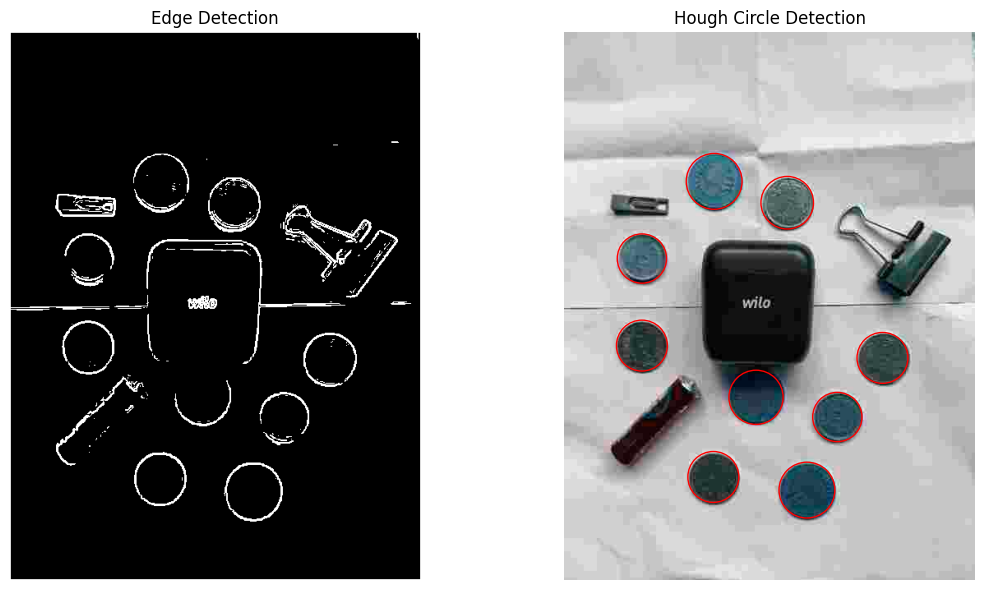

In [ ]:
img = cv2.imread('D:\\MSc Statistics SPPU\\IISER\\Images\\test3.0.jpg')
    
# Edge detection
edges = detect_edges(img, sobel_threshold=200)
# Hough Circle Transform
found_circles = hough_circles(edges, radius_range=(30, 40), votes_threshold=95, post_process=True, size=10, avg = "median")
print("Circles detected (x, y, r):", found_circles)
    
# Visualize results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(edges, cmap='gray')
axs[0].set_title('Edge Detection')
axs[0].axis('off')
# Plot circles on original image
axs[1].imshow(img, cmap='gray')
for (x, y, r) in found_circles:
    circ = plt.Circle((x, y), r, color='red', fill=False, linewidth=1)
    axs[1].add_patch(circ)
    # axs[1].plot(x, y, 'r+')
axs[1].set_title('Hough Circle Detection')
axs[1].axis('off')
plt.tight_layout()
plt.show()